In [24]:
# ==========================================
# 1. INSTALL LIBRARIES
# ==========================================
!pip install pytorch-tabnet
!pip install category_encoders

import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import torch


In [26]:
# Load CSV
df = pd.read_csv('/content/BetelPrice.csv')

# Drop blank last column if exists
if " " in df.columns:
    df = df.drop(columns=[" "])

print("Columns:", df.columns)
df.head()


Columns: Index(['Date', 'District', 'Market Type', 'Commercial Type', 'Quality Grade',
       'Price', 'Unnamed: 6'],
      dtype='object')


,Date,District,Market Type,Commercial Type,Quality Grade,Price,Unnamed: 6
0,1/5/2016,Kurunegala,Export,Peedunu,Premium,4500,NaN
1,1/5/2016,Kurunegala,Export,Peedunu,Standard,2000,NaN
2,1/5/2016,Kurunegala,Export,Kanda,Premium,5000,NaN
3,1/5/2016,Kurunegala,Export,Kanda,Standard,2000,NaN
4,1/5/2016,Kurunegala,Local,Peedunu,Premium,3000,NaN


In [27]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Create Year, Month, Week
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)


In [28]:
cat_cols = ["District", "Market Type", "Commercial Type", "Quality Grade"]
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le


In [29]:
features = ["District", "Market Type", "Commercial Type", "Quality Grade",
            "Year", "Month", "Week"]
target = ["Price"]

X = df[features].values
y = df[target].values


In [30]:
# First split: Train + Temp (Temp will be split into Val and Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Second split: Validation / Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (6600, 7)
Validation shape: (1414, 7)
Test shape: (1415, 7)


In [31]:
tabnet = TabNetRegressor(
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    mask_type='entmax'
)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [32]:
tabnet.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['mae'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
)


epoch 0  | loss: 16240726.52| val_0_mae: 2854.90332|  0:00:00s
epoch 1  | loss: 16374502.4| val_0_mae: 2343.56128|  0:00:01s
epoch 2  | loss: 16192551.6| val_0_mae: 2381.34937|  0:00:02s
epoch 3  | loss: 16292627.76| val_0_mae: 2338.66089|  0:00:02s
epoch 4  | loss: 16425868.8| val_0_mae: 2616.35986|  0:00:03s
epoch 5  | loss: 16308286.84| val_0_mae: 2740.00732|  0:00:04s
epoch 6  | loss: 16377748.16| val_0_mae: 2858.03735|  0:00:04s
epoch 7  | loss: 16047586.36| val_0_mae: 2958.42627|  0:00:05s
epoch 8  | loss: 16446106.2| val_0_mae: 3055.86133|  0:00:06s
epoch 9  | loss: 16171248.08| val_0_mae: 3137.58228|  0:00:06s
epoch 10 | loss: 16414656.12| val_0_mae: 3214.25806|  0:00:07s
epoch 11 | loss: 16140895.6| val_0_mae: 3109.05664|  0:00:08s
epoch 12 | loss: 16328439.92| val_0_mae: 3232.81616|  0:00:08s
epoch 13 | loss: 16200230.56| val_0_mae: 3284.88403|  0:00:09s
epoch 14 | loss: 16306523.08| val_0_mae: 3331.02441|  0:00:09s
epoch 15 | loss: 16131877.2| val_0_mae: 3374.53149|  0:00:10

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [34]:
preds = tabnet.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Test MAE:", mae)
print("Test RMSE:", rmse)


Test MAE: 4275.13330078125
Test RMSE: 5728.090781403521


In [35]:
def predict_price(District, Market_Type, Commercial_Type, Quality_Grade, Date):
    Date = pd.to_datetime(Date)

    inp = np.array([[
        encoders["District"].transform([District])[0],
        encoders["Market Type"].transform([Market_Type])[0],
        encoders["Commercial Type"].transform([Commercial_Type])[0],
        encoders["Quality Grade"].transform([Quality_Grade])[0],
        Date.year,
        Date.month,
        Date.isocalendar().week
    ]])

    pred = tabnet.predict(inp)[0][0]
    return round(pred, 2)


In [36]:
predict_price(
    District="Gampaha",
    Market_Type="Export",
    Commercial_Type="Peedunu",
    Quality_Grade="Premium",
    Date="2025-01-01"
)


np.float32(2196.16)

In [37]:
# Predict on test set
preds = tabnet.predict(X_test)

# 1️⃣ Mean Absolute Error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")


Test MAE: 4275.13
Test RMSE: 5728.09
Test R² Score: -0.7054


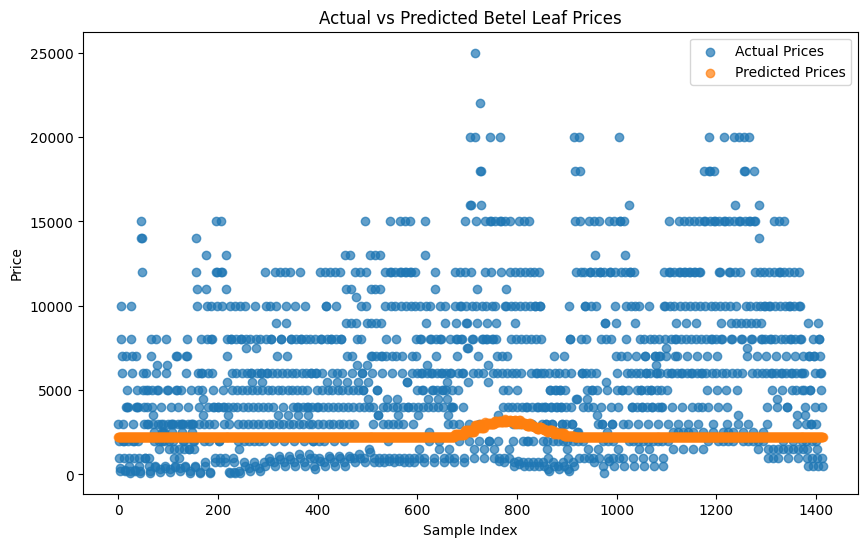

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, label='Actual Prices', alpha=0.7)
plt.scatter(range(len(y_test)), preds, label='Predicted Prices', alpha=0.7)
plt.title("Actual vs Predicted Betel Leaf Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.show()
